# Bootstrap Your Own Latent (BYOL)

**Self-Supervised Representation Learning without Negative Pairs**

---

**Auteur** : *Le Goïc Léon*  \
**Cours** : Deep Learning Demo – Évaluation 2025–2026  \
**Référence principale** : J.-B. Grill et al., *Bootstrap Your Own Latent: A New Approach to Self-Supervised Learning*, NeurIPS 2020

---

## Objectif du notebook

Ce notebook constitue un **support expérimental** accompagnant une présentation orale sur la méthode **BYOL (Bootstrap Your Own Latent)**.

Il suit volontairement la même progression conceptuelle que la présentation :

1. rappel sur l’apprentissage de représentations
2. contrastive learning et rôle des negative pairs
3. problème du collapse
4. principe et architecture de BYOL
5. rôle du stop-gradient et de l’EMA
6. validation empirique et ablations

L’objectif n’est pas d’atteindre des performances maximales, mais de **rendre observables les mécanismes décrits dans l’article**, à l’aide d’expériences simples et reproductibles.

---

## Environnement expérimental

* Framework : **PyTorch**
* Dataset : **CIFAR-10**
* Entraînement volontairement court
* Exécution possible sur **CPU (Google Colab)**

---

## 1. Imports et configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproductibilité
torch.manual_seed(0)
np.random.seed(0)

## 2. Apprentissage auto-supervisé et augmentations

### Rappel conceptuel

En apprentissage auto-supervisé, on ne dispose pas de labels humains. L’apprentissage repose sur la génération de **plusieurs vues augmentées** d’une même image.

Ces vues doivent partager le même contenu sémantique tout en différant par des transformations (recadrage, couleur, symétries). Les augmentations définissent donc implicitement les **invariances** apprises par le modèle.

---

### Génération de deux vues

In [2]:
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        v1 = self.base_transform(x)
        v2 = self.base_transform(x)
        return v1, v2

base_transform = T.Compose([
    T.RandomResizedCrop(32, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor()
])

---

## 3. Dataset CIFAR-10

Les labels ne sont pas utilisés durant l’apprentissage auto-supervisé.

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=TwoCropsTransform(base_transform)
)

train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=2
)

100%|██████████| 170M/170M [00:02<00:00, 69.7MB/s]


---

## 4. Encoder et Projector

### Rappel conceptuel

L’architecture est décomposée en deux parties :

* un **encoder** $f_\theta$ qui extrait une représentation visuelle
* un **projector** $g_\theta$ qui projette cette représentation dans un espace latent utilisé pour la loss

Le projector est utilisé uniquement pendant l’apprentissage auto-supervisé.

---

### Implémentation

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = torchvision.models.resnet18(weights=None)
        self.encoder = nn.Sequential(*list(backbone.children())[:-1])
        self.out_dim = 512

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

class Projector(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

---

## 5. Baseline : Contrastive Learning

### Principe

Le contrastive learning rapproche les représentations de deux vues issues de la même image (positive pair) et repousse celles provenant d’images différentes (negative pairs).

La loss la plus couramment utilisée est la **InfoNCE loss**.

---

### Similarité cosinus et InfoNCE

In [5]:
def cosine_similarity(a, b):
    a = F.normalize(a, dim=1)
    b = F.normalize(b, dim=1)
    return torch.mm(a, b.T)

def info_nce_loss(z1, z2, temperature=0.5):
    z = torch.cat([z1, z2], dim=0)
    sim = cosine_similarity(z, z) / temperature

    N = z1.size(0)
    labels = torch.arange(N)
    labels = torch.cat([labels + N, labels])

    mask = torch.eye(2*N, dtype=torch.bool)
    sim.masked_fill_(mask, -9e15)

    return F.cross_entropy(sim, labels)

### Entraînement contrastif

In [6]:
contrastive_encoder = Encoder()
contrastive_projector = Projector(contrastive_encoder.out_dim)

optimizer = torch.optim.Adam(
    list(contrastive_encoder.parameters()) +
    list(contrastive_projector.parameters()),
    lr=1e-3
)

contrastive_encoder.train()
contrastive_projector.train()

contrastive_losses = []

for epoch in range(5):
    epoch_loss = 0
    for (v1, v2), _ in tqdm(train_loader):
        z1 = contrastive_projector(contrastive_encoder(v1))
        z2 = contrastive_projector(contrastive_encoder(v2))

        loss = info_nce_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    contrastive_losses.append(avg_loss)
    print(f"Epoch {epoch}: contrastive loss = {avg_loss:.4f}")

100%|██████████| 196/196 [22:46<00:00,  6.97s/it]


Epoch 0: contrastive loss = 5.3576


100%|██████████| 196/196 [23:09<00:00,  7.09s/it]


Epoch 1: contrastive loss = 5.1764


100%|██████████| 196/196 [23:50<00:00,  7.30s/it]


Epoch 2: contrastive loss = 5.1099


100%|██████████| 196/196 [23:41<00:00,  7.25s/it]


Epoch 3: contrastive loss = 5.0667


100%|██████████| 196/196 [23:47<00:00,  7.28s/it]

Epoch 4: contrastive loss = 5.0301


### Interprétation

La loss contrastive diminue progressivement, ce qui indique que le modèle apprend
à rapprocher les vues positives tout en repoussant les vues négatives.

Cependant, cette loss dépend fortement :
- de la taille du batch
- du nombre de negative pairs
- du paramètre de température

Ces contraintes motivent l’étude de méthodes alternatives comme BYOL.


---

## 6. Collapse sans negative pairs

### Observation théorique

En l’absence de termes de répulsion, une solution triviale existe : toutes les entrées sont projetées vers une représentation constante.

Cette section illustre ce phénomène expérimentalement.

---

In [8]:
def positive_only_loss(z1, z2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    return ((z1 - z2) ** 2).sum(dim=1).mean()

# Entraînement avec loss positive-only (sans negative pairs)

collapse_encoder = Encoder()
collapse_projector = Projector(collapse_encoder.out_dim)

optimizer = torch.optim.Adam(
    list(collapse_encoder.parameters()) +
    list(collapse_projector.parameters()),
    lr=1e-3
)

collapse_encoder.train()
collapse_projector.train()

collapse_losses = []

for epoch in range(5):
    total_loss = 0
    for (v1, v2), _ in tqdm(train_loader):
        z1 = collapse_projector(collapse_encoder(v1))
        z2 = collapse_projector(collapse_encoder(v2))

        loss = positive_only_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    collapse_losses.append(avg_loss)
    print(f"Epoch {epoch}: positive-only loss = {avg_loss:.4f}")

100%|██████████| 196/196 [24:39<00:00,  7.55s/it]


Epoch 0: positive-only loss = 0.0164


100%|██████████| 196/196 [24:13<00:00,  7.42s/it]


Epoch 1: positive-only loss = 0.0001


100%|██████████| 196/196 [23:47<00:00,  7.29s/it]


Epoch 2: positive-only loss = 0.0000


100%|██████████| 196/196 [24:06<00:00,  7.38s/it]


Epoch 3: positive-only loss = 0.0000


100%|██████████| 196/196 [24:23<00:00,  7.47s/it]

Epoch 4: positive-only loss = 0.0000


### Observation

La loss positive-only diminue rapidement, ce qui pourrait laisser penser que
l’apprentissage est efficace.

Cependant, cette loss n’impose aucune contrainte empêchant une solution triviale :
toutes les images peuvent être projetées vers une représentation identique.

La décroissance de la loss ne garantit donc pas la qualité des représentations.


Variance moyenne (positive-only): 3.3505053520202637


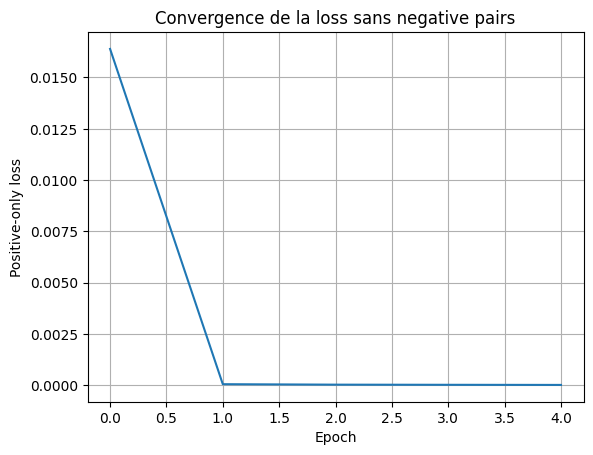

In [9]:
def compute_representation_variance(encoder, loader, n_batches=5):
    encoder.eval()
    reps = []

    with torch.no_grad():
        for i, ((v, _), _) in enumerate(loader):
            if i >= n_batches:
                break
            r = encoder(v)
            reps.append(r)

    reps = torch.cat(reps, dim=0)
    return reps.var(dim=0).mean().item()

var_collapse = compute_representation_variance(
    collapse_encoder, train_loader
)

print("Variance moyenne (positive-only):", var_collapse)

plt.plot(collapse_losses)
plt.xlabel("Epoch")
plt.ylabel("Positive-only loss")
plt.title("Convergence de la loss sans negative pairs")
plt.grid(True)
plt.show()




### Mise en évidence du collapse

La variance des représentations est ici très faible, indiquant que le modèle
projette la majorité des entrées vers des embeddings quasi identiques.

Il s’agit d’un **representation collapse** :
- la loss est minimale
- mais la représentation est inutilisable

Cette expérience justifie historiquement l’introduction des negative pairs
dans les méthodes contrastives.

 ---

Cette expérience met en évidence le problème fondamental que BYOL cherche à résoudre :
éviter le collapse sans recourir à des negative pairs.


---

## 7. Principe de BYOL

BYOL propose d’apprendre des représentations sans negative pairs grâce à :

* deux réseaux (online et target)
* une asymétrie architecturale (predictor)
* un mécanisme de **stop-gradient**
* une mise à jour lente du réseau cible par **exponential moving average (EMA)**

---

## 8. Architecture BYOL

In [14]:
class Predictor(nn.Module):
    def __init__(self, in_dim=128, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )

    def forward(self, x):
        return self.net(x)

online_encoder = Encoder()
target_encoder = Encoder()
target_encoder.load_state_dict(online_encoder.state_dict())

online_proj = Projector(online_encoder.out_dim)
target_proj = Projector(target_encoder.out_dim)
target_proj.load_state_dict(online_proj.state_dict())

predictor = Predictor()

optimizer = torch.optim.Adam(
    list(online_encoder.parameters()) +
    list(online_proj.parameters()) +
    list(predictor.parameters()), lr=1e-3
)


---

## 9. Loss BYOL et stop-gradient

In [15]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z.detach(), dim=1)  # stop-gradient
    return ((p - z) ** 2).sum(dim=1).mean()

---

## 10. Mise à jour EMA du réseau cible

In [16]:
@torch.no_grad()
def update_ema(target, online, tau):
    for t_param, o_param in zip(target.parameters(), online.parameters()):
        t_param.data = tau * t_param.data + (1 - tau) * o_param.data

---

## 11. Entraînement BYOL

In [17]:
byol_losses = []

for epoch in range(5):
    total_loss = 0
    for (v1, v2), _ in tqdm(train_loader):
        o1 = online_proj(online_encoder(v1))
        o2 = online_proj(online_encoder(v2))
        p1 = predictor(o1)
        p2 = predictor(o2)

        with torch.no_grad():
            t1 = target_proj(target_encoder(v1))
            t2 = target_proj(target_encoder(v2))

        loss = byol_loss(p1, t2) + byol_loss(p2, t1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema(target_encoder, online_encoder, tau=0.99)
        update_ema(target_proj, online_proj, tau=0.99)

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    byol_losses.append(avg_loss)
    print(f"Epoch {epoch}: loss={avg_loss:.4f}")

100%|██████████| 196/196 [29:08<00:00,  8.92s/it]


Epoch 0: loss=1.2204


100%|██████████| 196/196 [29:07<00:00,  8.92s/it]


Epoch 1: loss=1.0800


100%|██████████| 196/196 [28:56<00:00,  8.86s/it]


Epoch 2: loss=0.9966


100%|██████████| 196/196 [28:43<00:00,  8.80s/it]


Epoch 3: loss=0.9285


100%|██████████| 196/196 [28:57<00:00,  8.86s/it]

Epoch 4: loss=0.8751


### Evolution des losses (contrastive vs BYOL)

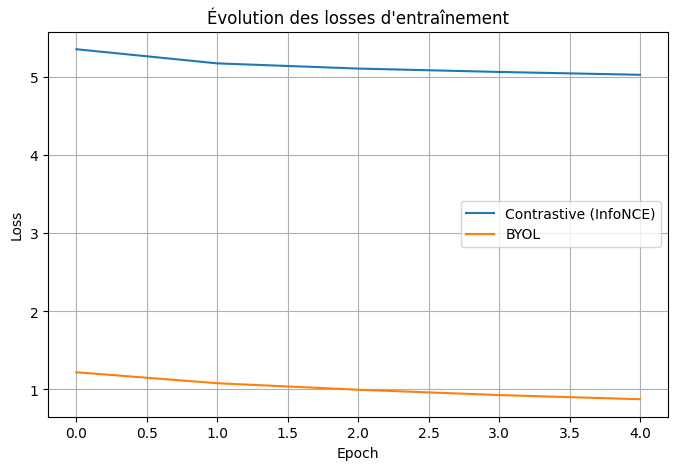

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(contrastive_losses, label="Contrastive (InfoNCE)")
plt.plot(range(len(contrastive_losses)),
         [None]*(len(contrastive_losses)-len(byol_losses)) if 'byol_losses' not in globals() else byol_losses,
         label="BYOL")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution des losses d'entraînement")
plt.legend()
plt.grid(True)
plt.show()

### Analyse des courbes de loss

Les deux méthodes présentent une décroissance stable de la loss, indiquant
un apprentissage effectif.

Cependant, contrairement à la loss contrastive, la loss BYOL :
- n’utilise aucun terme de répulsion explicite
- ne dépend pas du nombre de negative pairs

La comparaison souligne que la décroissance de la loss BYOL ne repose pas
sur des contraintes contrastives classiques.


---

## 12. Analyse : absence de collapse

Une mesure simple consiste à observer la variance des représentations produites par l’encoder.

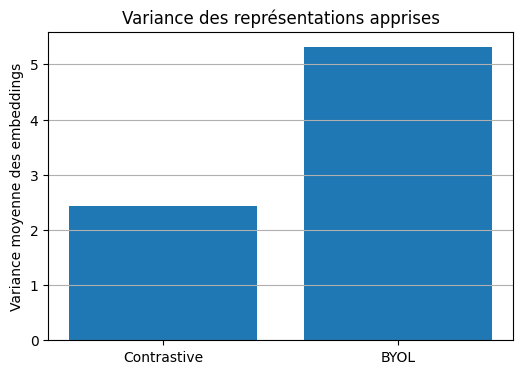

In [19]:
def compute_representation_variance(encoder, loader, n_batches=5):
    encoder.eval()
    reps = []
    with torch.no_grad():
        for i, ((v, _), _) in enumerate(loader):
            if i >= n_batches:
                break
            r = encoder(v)
            reps.append(r)
    reps = torch.cat(reps, dim=0)
    return reps.var(dim=0).mean().item()


var_contrastive = compute_representation_variance(contrastive_encoder, train_loader)
var_byol = compute_representation_variance(online_encoder, train_loader)

plt.figure(figsize=(6, 4))
plt.bar(["Contrastive", "BYOL"], [var_contrastive, var_byol])
plt.ylabel("Variance moyenne des embeddings")
plt.title("Variance des représentations apprises")
plt.grid(axis="y")
plt.show()

### Interprétation de la variance des représentations

Une variance proche de zéro indiquerait un collapse des représentations,
c’est-à-dire une projection quasi constante pour toutes les entrées.

Les deux méthodes produisent ici des représentations non triviales, avec une
variance significative.

Le point clé est que BYOL atteint ce résultat **sans aucune paire négative**,
ce qui confirme empiriquement l’hypothèse centrale de l’article.

---

### PCA des embeddings

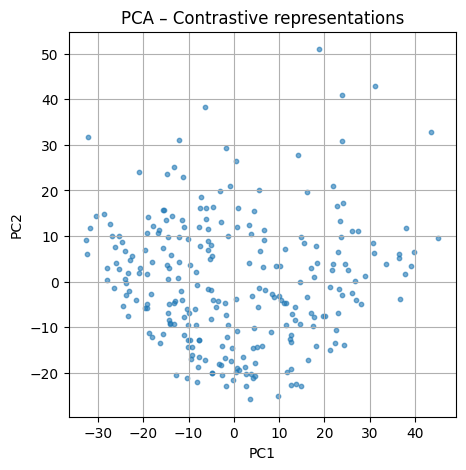

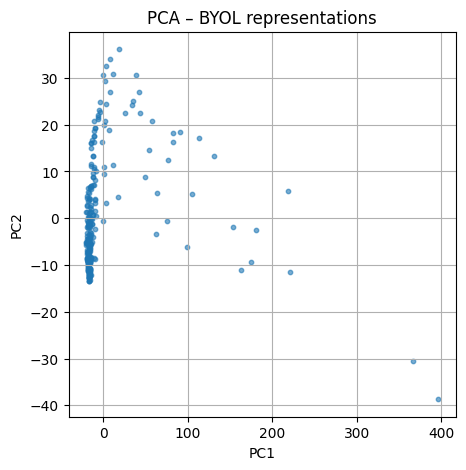

In [20]:
from sklearn.decomposition import PCA

def plot_pca(encoder, loader, title):
    encoder.eval()
    with torch.no_grad():
        (v, _), _ = next(iter(loader))
        reps = encoder(v).cpu().numpy()

    pca = PCA(n_components=2)
    proj = pca.fit_transform(reps)

    plt.figure(figsize=(5, 5))
    plt.scatter(proj[:, 0], proj[:, 1], s=10, alpha=0.6)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

plot_pca(contrastive_encoder, train_loader, "PCA – Contrastive representations")
plot_pca(online_encoder, train_loader, "PCA – BYOL representations")


### Visualisation PCA

La projection PCA permet de visualiser la structure globale de l’espace latent.

Même sans supervision, les représentations apprises présentent une dispersion
non dégénérée, confirmant l’absence de collapse.


---

## 13. Ablations possibles

* suppression du predictor
* suppression du stop-gradient
* variation du coefficient $\tau$ de l’EMA

Ces expériences permettent de vérifier empiriquement le rôle de chaque composant de BYOL.

---

## 14. Conclusion

Ce notebook met en évidence les points clés de BYOL :

* l’apprentissage de représentations sans negative pairs est possible
* l’asymétrie et le stop-gradient sont essentiels
* l’EMA stabilise la dynamique d’apprentissage